In [1]:
pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 3.5 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import wfdb
import ast
import os
from joblib import Parallel, delayed
import random
import matplotlib.pyplot as plt
from scipy.signal import sawtooth
import seaborn as sns

sns.set()
seed = 2025
np.random.seed(seed)
random.seed(seed)

pd.set_option('display.max_columns', 30)
base_dir = "/kaggle/input/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3"
sampling_rate=100

df_meta = pd.read_csv(os.path.join(base_dir,'ptbxl_database.csv'), index_col='ecg_id')

In [3]:
%%time
def read_signal(path, filename):
    signal, _ = wfdb.rdsamp(os.path.join(path, filename))
    return signal

Y = np.array(Parallel(n_jobs=-1)(delayed(read_signal)(base_dir, f) for f in df_meta.filename_lr)) # fs=100
X = Y

CPU times: user 6.9 s, sys: 4.23 s, total: 11.1 s
Wall time: 1min 46s


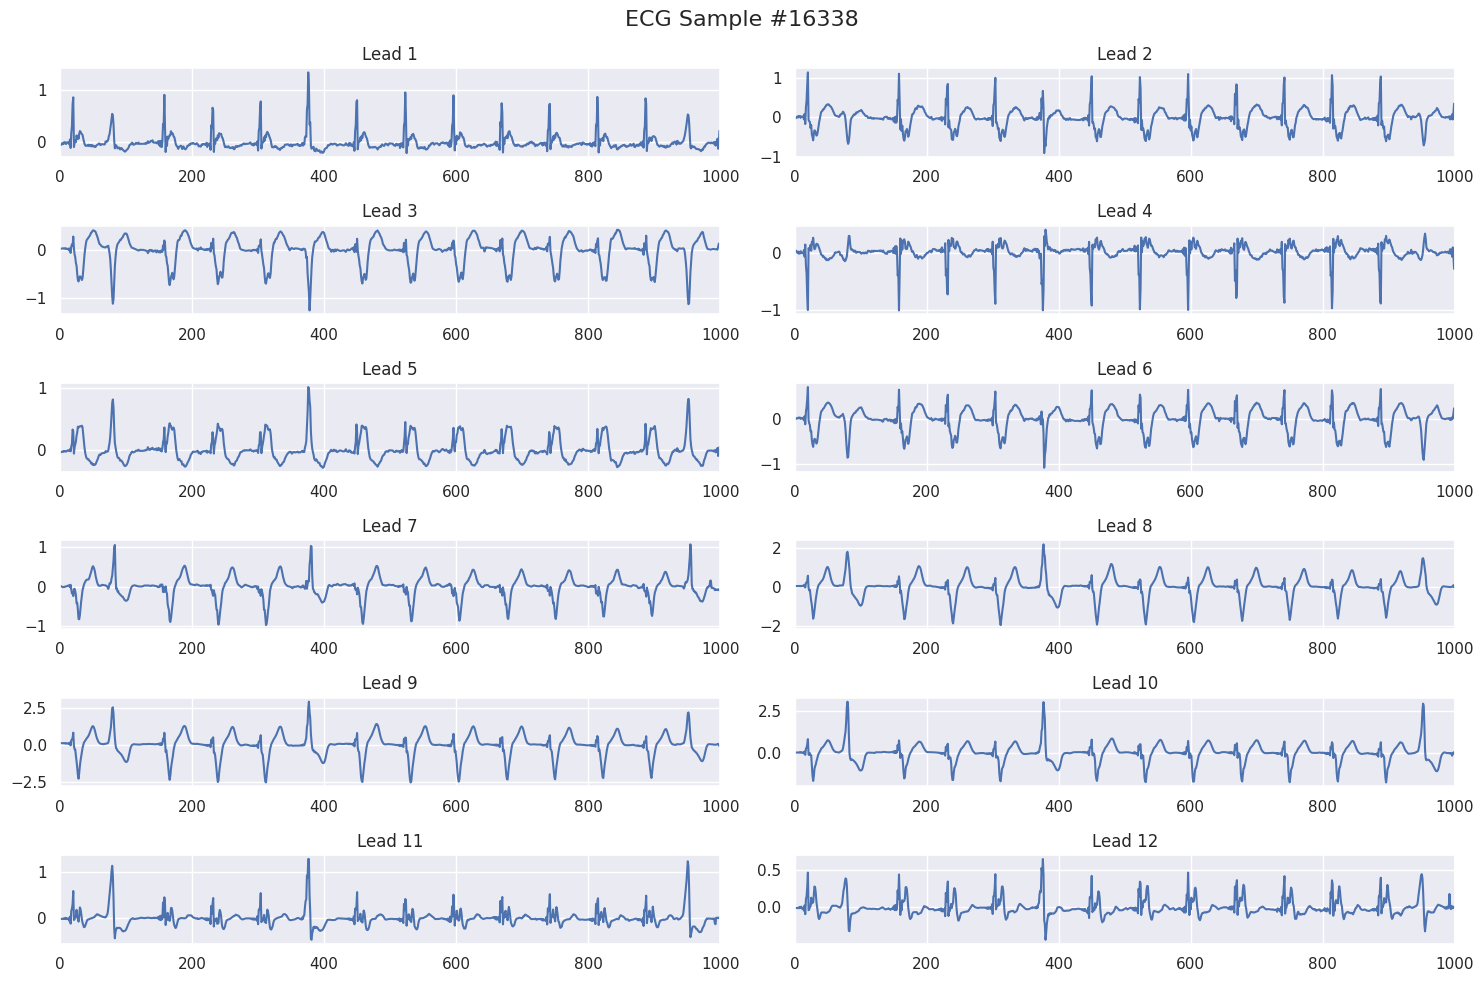

In [4]:
i = np.random.randint(X.shape[0])
sample = X[i]  # shape: (1000, 12)

fig, axs = plt.subplots(6, 2, figsize=(15, 10))
fig.suptitle(f"ECG Sample #{i}", fontsize=16)

for lead in range(12):
    ax = axs[lead // 2, lead % 2]
    ax.plot(sample[:, lead], label=f"Lead {lead+1}")
    ax.set_title(f"Lead {lead+1}")
    ax.set_xlim(0, 1000)

plt.tight_layout()
plt.show()

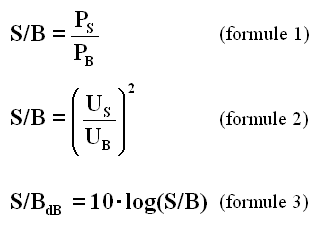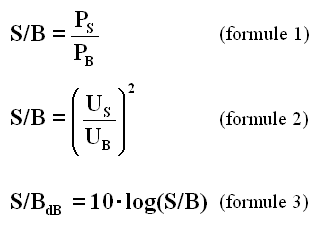

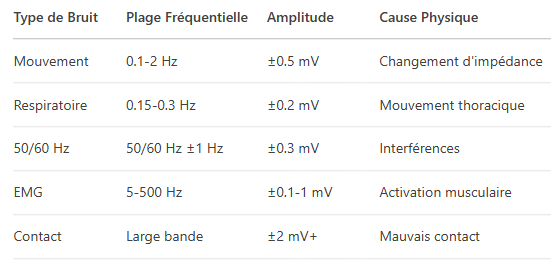

Applying noise: add_motion_noise with snr_db: 22


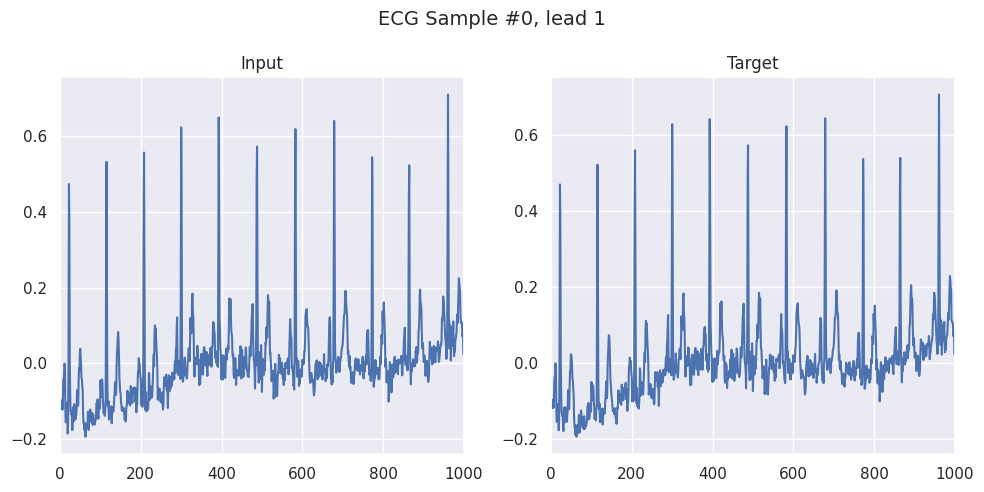

In [5]:
def add_gaussian_noise(signal, snr_db):
    Ps = np.mean(signal**2)
    Pb = Ps / 10**(snr_db / 10)
    noise = np.random.normal(0, np.sqrt(Pb), signal.shape)
    return signal + noise
    
def add_motion_noise(signal, snr_db, fs=100):
    t = np.arange(0, len(signal))/fs
    Ps = np.mean(signal**2)
    P_target = Ps / 10**(snr_db / 10)
    noise = 0.5*np.sin(2*np.pi*0.3 * t) + 0.2*np.random.randn(len(signal))
    Pb = np.mean(noise**2)
    scale = np.sqrt(P_target/Pb)
    noise = noise * scale
    return signal + noise

def add_resp_noise(signal, snr_db, fs=100):
    t = np.arange(0, len(signal))/fs
    Ps = np.mean(signal**2)
    P_target = Ps / 10**(snr_db / 10)
    noise = 0.2*(np.sin(2*np.pi*0.25 * t) + 0.3*np.sin(2*np.pi*0.1 * t))
    Pb = np.mean(noise**2)
    scale = np.sqrt(P_target/Pb)
    noise = noise * scale
    return signal + noise

def add_electrode_noise(signal, snr_db, fs=100):
    t = np.arange(0, len(signal))/fs
    Ps = np.mean(signal**2)
    P_target = Ps / 10**(snr_db / 10)
    noise = 0.3*sawtooth(2*np.pi*50 * t, width=0.5)
    Pb = np.mean(noise**2)
    scale = np.sqrt(P_target/Pb)
    noise = noise * scale
    return signal + noise

def apply_random_noise(signal, snr_db, verbose=True):
    noise_funcs = [
        add_gaussian_noise,
        add_motion_noise,
        add_resp_noise,
        add_electrode_noise
    ]
    noise_func = random.choice(noise_funcs)
    if verbose:
        print(f"Applying noise: {noise_func.__name__} with snr_db: {snr_db}")
    return noise_func(signal, snr_db)

def plot_noise_target(i):
    signal = X[i][:,0]
    snr_db = random.randint(15, 24) if random.random() < 0.6 else random.randint(6, 14)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f"ECG Sample #{i}, lead 1", fontsize=14)
    axs[0].plot(apply_random_noise(signal,snr_db))
    axs[0].set_xlim(0, 1000)
    axs[0].set_title('Input')
    axs[1].plot(signal)
    axs[1].set_xlim(0, 1000)
    axs[1].set_title('Target')
    plt.tight_layout()
    plt.show()

plot_noise_target(0)

In [6]:
%%time
def make_inputs_targets(X, Y):
    # Input shape : n * 1000 * 12
    X = X.transpose(0,2,1).reshape(-1, 1000)
    Y = Y.transpose(0,2,1).reshape(-1, 1000)
    for i in range(len(X)):
        snr_db = random.randint(15, 24) if random.random() < 0.6 else random.randint(6, 14)
        X[i,:] = apply_random_noise(X[i,:], snr_db, False)
    return X, Y  

X, Y = make_inputs_targets(X, Y)

CPU times: user 31.5 s, sys: 1.38 s, total: 32.9 s
Wall time: 32.9 s


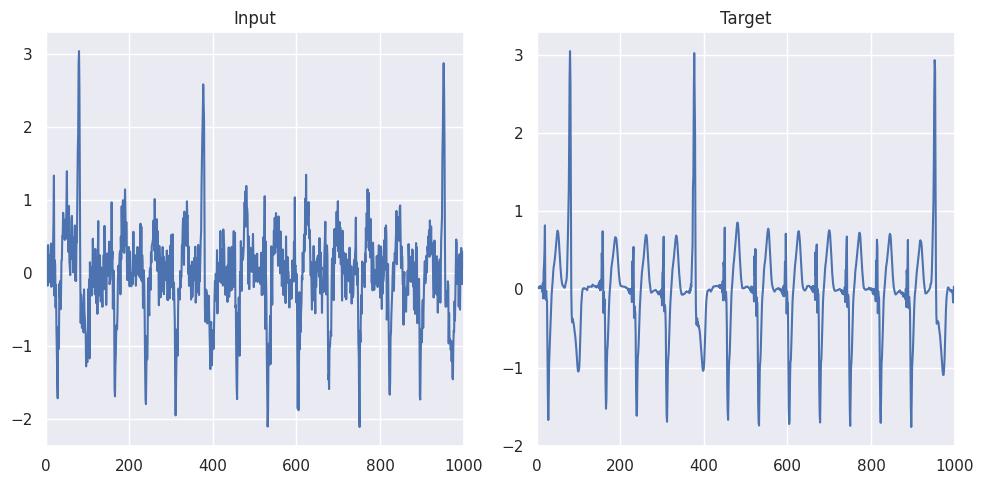

In [7]:
def plot_input_target(i):
    noise = X[i]
    target = Y[i]
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(noise)
    axs[0].set_xlim(0, 1000)
    axs[0].set_title('Input')
    axs[1].plot(target)
    axs[1].set_xlim(0, 1000)
    axs[1].set_title('Target')
    plt.tight_layout()
    plt.show()

plot_input_target(12*16338+9)

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=seed)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=seed)

In [9]:
np.save('X_train.npy', X_train)
np.save('Y_train.npy', Y_train)
np.save('X_val.npy', X_val)
np.save('Y_val.npy', Y_val)
np.save('X_test.npy', X_test)
np.save('Y_test.npy', Y_test)